In [ ]:
# ==============================================================================
# CE NOTEBOOKE EST LA MISE AU PROPRE DES NOTEBOOK :
#
# 4.0-fh-traducteur.ipynb & 4.0-fh-preparation-des-données.ipynb & 3.0-fdm-deep-et-machine-learning-texte
#
# ==============================================================================

In [ ]:
# ==============================================================================
# NOTEBOOK DE PREPARATION DES DONNEES (DATA CLEANING & FEATURE ENGINNEERING)
#
# Objectifs :
#
# - Préparer et nettoyer les données textuelles.
# - Détecter la langue de chaque texte et traduire les textes non francophones en français.
# - Gérer le déséquilibre des classes en rééchantillonnant (sur-échantillonnage et sous-échantillonnage) les catégories de produits.
# - Encoder la variable cible "prdtypecode" en labels numériques.
# - Sauvegarder le jeu de données final, l'encodeur de labels et un fichier de mapping pour une utilisation future dans l'entraînement et le déploiement de modèles.
#
# ==============================================================================

In [ ]:
# Installation des packages
!pip install googletrans==4.0.0-rc1 deep_translator beautifulsoup4

!pip uninstall -y numpy
!pip install numpy==1.23.5 #installation de la version antérieure compatible avec fasttext
!pip install fasttext

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=dff6832596911f3161935bb4af4db273fd44c3ca94cf68492146739707271b2a
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperfram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313510 sha256=3e4b10b89e9e0b13d91407be2abe449ce06b3dcacc76c12846a1ea0b1e257c6e
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
# Montage de Google Drive pour accéder aux fichiers depuis Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ====== BIBLIOTHEQUES ======

# Importation des bibliothèques

# Bibliothèques standard
import os, time
import html
import joblib, json
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Traitement du texte & Traduction
import re
import fasttext
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

In [ ]:
#  Barre de progression pour apply
tqdm.pandas()

In [ ]:
# ====== NETTOYAGE DES DONNÉES ======

def nettoyage_html(texte):
    """
    Nettoie le texte de toutes les balises HTML et des encodages d'entités HTML ainsi que les espaces inutiles.

    La fonction traite les cas spéciaux comme '< 54 dBA' qui pourraient être
    confondus avec des balises HTML.

    Nous utilisons BeautifulSoup pour un nettoyage complet et robuste.

    Args :
        texte (str): Le texte à nettoyer pouvant contenir des entités ou balises HTML

    Returns :
        str: Le texte nettoyé
    """

    # Vérifie si le texte est NaN et retourne une chaîne vide si c'est le cas
    if pd.isna(texte):
        return ""

    # Convertit le texte en chaîne de caractères
    texte = str(texte)

    # Décodage HTML et suppression des balises
    texte = html.unescape(texte)
    texte = BeautifulSoup(texte, "html.parser").get_text(separator=" ")

    # Nettoie les cas comme "< 54 dBA" : supprime le < ou > et les éventuels espaces qui le suivent, en laissant le reste du motif intact.
    texte = re.sub(r'<\s*(\d+\s*[a-zA-Z]+)', r'\1', texte)
    texte = re.sub(r'>\s*(\d+\s*[a-zA-Z]+)', r'\1', texte)

    # Supprime toutes les balises restantes (ou tout texte entre < et >) et les remplace par un espace
    texte = re.sub(r'<[^>]+>', ' ', texte)

    # Normalisation des espaces
    texte = re.sub(r"\s+", " ", texte).strip()

    # Nettoie le texte en remplaçant les caractères de nouvelle ligne et en supprimant les espaces superflus
    texte = texte.replace("\n", " ").replace("\r", " ").strip()

    return texte

In [ ]:
# ====== DÉTECTION DE LANGUE ======

# Initialisation du modèle de détection
try:
    modele = fasttext.load_model('/content/drive/MyDrive/Colab Notebooks/data_rakuten/lid.176.bin')
except Exception as e:
    raise Exception(f"Erreur lors du chargement du modèle: {e}")

def detect_language(texte):
    """
    Détecte la langue d'un texte en utilisant un modèle fastText.

    Args :
        texte (str): Le texte dont on veut détecter la langue.

    Returns :
        str: La langue détectée ou 'unknown' si la détection échoue.
    """

    # Vérifier que le texte est une chaîne de caractères non vide
    if not isinstance(texte, str) or not texte.strip():
        return "unknown"

    try:
        # Prédire la langue du texte
        prediction = modele.predict(texte)
        # Extraire et retourner le label de la langue prédite
        return prediction[0][0].replace('__label__', '')
    except Exception as e:
        # En cas d'erreur, retourner 'unknown'
        print(f"Erreur lors de la détection de la langue: {e}")
        return "unknown"

In [ ]:
# ====== TRADUCTION DES TEXTES ======

# Découpage des textes > 5000 caractères
def decouper_texte(texte, max_length=5000):
    """
    Découpe un texte en morceaux de longueur maximale spécifiée.

    Args:
        texte (str): Le texte à découper.
        max_length (int): La longueur maximale de chaque morceau. Par défaut, 5000 caractères.

    Returns:
        list: Une liste de morceaux de texte.
    """
    if len(texte) <= max_length:
        return [texte]

    morceaux = []
    while len(texte) > max_length:
        # Trouver le dernier espace dans la limite de max_length
        cut_index = texte.rfind(' ', 0, max_length)
        if cut_index == -1:  # Si aucun espace n'est trouvé, couper à max_length
            cut_index = max_length
        morceaux.append(texte[:cut_index])
        texte = texte[cut_index:].strip()  # Supprimer les espaces en trop

    morceaux.append(texte)  # Ajouter le dernier morceau
    return morceaux

# Traduction sécurisée avec retry
def safe_translate(texts, retries=3):
    """
    Traduit une liste de textes en utilisant Google Translate avec gestion des erreurs et réessais.

    Args:
        texts (list): Une liste de textes à traduire.
        retries (int): Le nombre de tentatives de traduction en cas d'échec. Par défaut, 3.

    Returns:
        list: Une liste de textes traduits. En cas d'échec, retourne les textes originaux.
    """
    delay = 2  # Délai initial entre les tentatives
    for attempt in range(retries):
        try:
            # Utiliser Google Translate pour traduire le batch de textes
            translated_texts = GoogleTranslator(source='auto', target='fr').translate_batch(texts)
            return translated_texts
        except Exception as e:
            print(f"[Tentative {attempt + 1}] Erreur de traduction: {e}")
            time.sleep(delay)
            delay *= 2  # Augmenter le délai exponentiellement

    print("Échec de la traduction après plusieurs tentatives.")
    return texts  # Retourner les textes originaux en cas d'échec

In [ ]:
# ====== CHARGEMENT ET PRÉPARATION DES DONNÉES ======

# Chargement des données
x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_rakuten/X_train.csv", index_col=0)
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_rakuten/Y_train.csv", index_col=0)

# Fusion des données
df = x_train.join(y_train, how='inner') # L'option how='inner' conserve uniquement les lignes présentes dans les deux DataFrames

# Création d'une colonne combinant désignation et description
df["texte"] = df[["designation", "description"]].fillna("").agg(" ".join, axis=1)

# Création d'une colonne image produit
df["image_path"] = "image_" + df["imageid"].astype(str) + "_product_" + df["productid"].astype(str) + '.jpg'

# Suppression des colonnes inutilisées
df.drop(columns=["designation", "description", "imageid", "productid"], inplace=True)

df.head()

,prdtypecode,texte,image_path
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg


Répartition des catégories (prdtypecode) :

prdtypecode
2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: count, dtype: int64


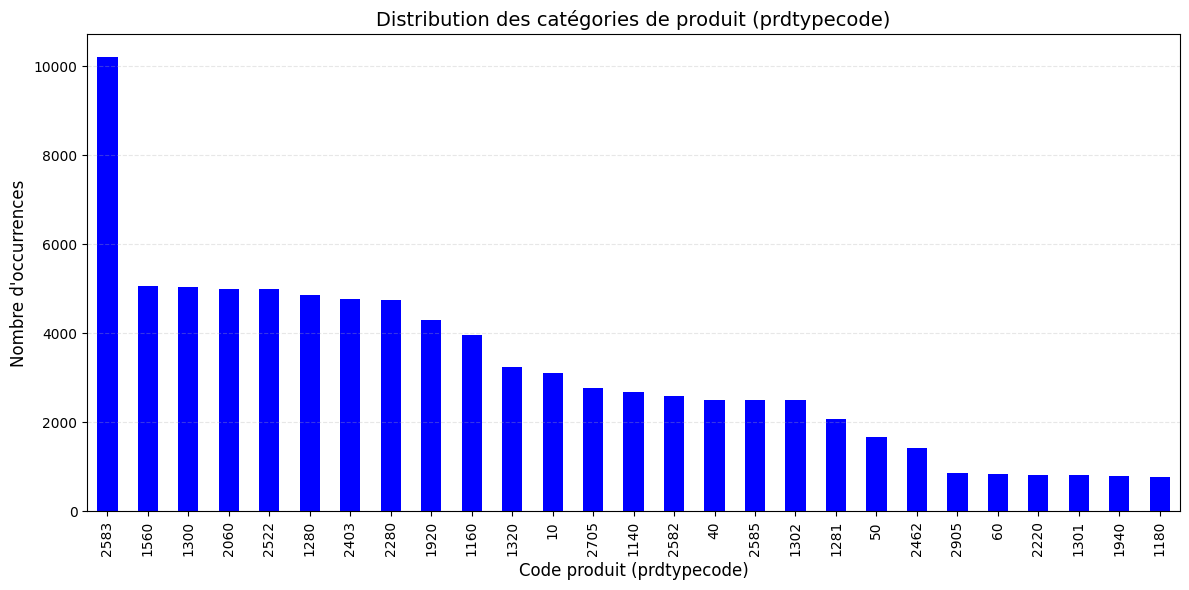

In [ ]:
# Calcul du nombre d'occurrences de chaque catégorie 'prdtypecode'
prdtypecode_counts = df['prdtypecode'].value_counts()
print("Répartition des catégories (prdtypecode) :\n")
print(prdtypecode_counts)

# Visualisation
plt.figure(figsize=(12, 6))

prdtypecode_counts.plot(kind='bar', color='blue')
plt.title("Distribution des catégories de produit (prdtypecode)", fontsize=14)
plt.xlabel("Code produit (prdtypecode)", fontsize=12)
plt.ylabel("Nombre d'occurrences", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Application du nettoyage HTML
print("Nettoyage en cours...")
df['texte_nettoye'] = df['texte'].apply(nettoyage_html)

df.head()

Nettoyage en cours...


,prdtypecode,texte,image_path,texte_nettoye
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg,La Guerre Des Tuques Luc a des idées de grande...


In [ ]:
# Détection de la langue pour tous les textes
print("Détection de la langue en cours...")
df['langue'] = df['texte_nettoye'].apply(detect_language)

lang_value = df['langue'].value_counts()
display(df['langue'].value_counts().head(5))
display(df['langue'].value_counts(normalize=True).head(5))

df.head()

Détection de la langue en cours...


,count
langue,
fr,69706
en,12927
de,685
es,547
nl,367


,proportion
langue,
fr,0.820882
en,0.152233
de,0.008067
es,0.006442
nl,0.004322


,prdtypecode,texte,image_path,texte_nettoye,langue
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,Olivia: Personalisiertes Notizbuch / 150 Seite...,de
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg,Peluche Donald - Europe - Disneyland 2000 (Mar...,fr
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg,La Guerre Des Tuques Luc a des idées de grande...,fr


In [ ]:
# Sauvegarde du fichier final nettoyé
output_path = "/content/drive/MyDrive/Colab Notebooks/data_rakuten/X_train_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"\n Nettoyage terminé et fichier sauvegardé ici : {output_path}")


 Nettoyage terminé et fichier sauvegardé ici : /content/drive/MyDrive/Colab Notebooks/data/X_train_cleaned.csv


In [ ]:
# Chemin vers le fichier CSV de sauvegarde
source_path = "/content/drive/MyDrive/Colab Notebooks/data_rakuten/X_train_cleaned.csv"
csv_save_path = "/content/drive/MyDrive/Colab Notebooks/data_rakuten/X_train_cleaned_fr.csv"

# Charger le DataFrame
if os.path.exists(csv_save_path):
    df = pd.read_csv(csv_save_path)
    print("Fichier CSV trouvé. Reprise sur base existante.")
else:
    df = pd.read_csv(source_path) # Chargement du fichier à traduire
    df["texte_nettoye_traduit"] = None
    print("Nouveau fichier initialisé.")

# Lignes non traduites
rows_to_translate = df[df['texte_nettoye_traduit'].isna()]
print(f"\nLignes à traduire : {len(rows_to_translate)}\n")

df.head()

Fichier CSV trouvé. Reprise sur base existante.

Lignes à traduire : 0



,prdtypecode,texte,image_path,texte_nettoye,langue,texte_nettoye_traduit
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,Olivia: cahier personnalisé / 150 pages / gril...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg,Peluche Donald - Europe - Disneyland 2000 (Mar...,fr,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg,La Guerre Des Tuques Luc a des idées de grande...,fr,La Guerre Des Tuques Luc a des idées de grande...


In [ ]:
# Boucle principale pour traduire les lignes non traduites
for index, row in tqdm(rows_to_translate.iterrows(), total=len(rows_to_translate), desc="Traduction globale"):
    # Extraire et nettoyer le texte de la ligne actuelle
    texte = str(row['texte_nettoye']).strip()

    # Si le texte est vide, marquer comme traduit vide et passer à la ligne suivante
    if not texte:
        df.at[index, 'texte_nettoye_traduit'] = ""
        continue

    # Vérifier si le texte est déjà en français
    if row['langue'] == 'fr':  # Utiliser 'row' pour accéder à la colonne 'langue'
        df.at[index, 'texte_nettoye_traduit'] = texte
    else:
        # Découper le texte en morceaux si sa longueur dépasse 5000 caractères
        morceaux = decouper_texte(texte)
        print(f"\nTexte > 5000 à traduire en {len(morceaux)} morceaux (ligne {index})...")

        # Liste pour stocker les morceaux traduits
        traduction_complete = []
        # Traduire chaque morceau du texte
        for i, morceau in enumerate(tqdm(morceaux, desc=f"  ↪️ Batch ligne {index}", leave=False)):
            trad = safe_translate([morceau])[0]
            traduction_complete.append(trad)
            time.sleep(1)  # Pause pour éviter de surcharger l'API

        # Combiner les morceaux traduits en un seul texte
        df.at[index, 'texte_nettoye_traduit'] = " ".join(traduction_complete)

    # Sauvegarde intermédiaire toutes les 50 lignes pour éviter de perdre les progrès
    if index % 50 == 0:
        df.to_csv(csv_save_path, index=False)
        print(f"Sauvegarde intermédiaire à la ligne {index}")

# Sauvegarde finale du DataFrame dans un fichier CSV
df.to_csv(csv_save_path, index=False)
print("\nTraduction complète sauvegardée (.csv).")

Traduction globale: 0it [00:00, ?it/s]



Traduction complète sauvegardée (.csv).


In [ ]:
final_path="/content/drive/MyDrive/Colab Notebooks/data_rakuten/"

# Chargement du fichier traduit
df = pd.read_csv(f"{final_path}X_train_cleaned_fr.csv")

# On garde uniquement les lignes traduites + chemin image non vide
df = df[df["texte_nettoye_traduit"].notna()]
df = df[df["image_path"].notna() & df["image_path"].str.strip().ne("")].copy()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   prdtypecode            84916 non-null  int64 
 1   texte                  84916 non-null  object
 2   image_path             84916 non-null  object
 3   texte_nettoye          84916 non-null  object
 4   langue                 84916 non-null  object
 5   texte_nettoye_traduit  84916 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.9+ MB


,prdtypecode,texte,image_path,texte_nettoye,langue,texte_nettoye_traduit
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,Olivia: cahier personnalisé / 150 pages / gril...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg,Peluche Donald - Europe - Disneyland 2000 (Mar...,fr,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg,La Guerre Des Tuques Luc a des idées de grande...,fr,La Guerre Des Tuques Luc a des idées de grande...


Rééquilibrage des classes en cours...


Catégories: 100%|██████████| 27/27 [00:00<00:00, 345.27it/s]


Répartition des classes après équilibrage :
prdtypecode
1560    5000
1300    5000
2583    5000
2060    4993
2522    4989
1280    4870
2403    4774
2280    4760
1920    4303
1160    3953
1320    3241
10      3116
2705    2761
1140    2671
2582    2589
40      2508
2585    2496
1302    2491
1281    2070
2220    2000
2905    2000
1940    2000
1180    2000
60      2000
2462    2000
50      2000
1301    2000
Name: count, dtype: int64


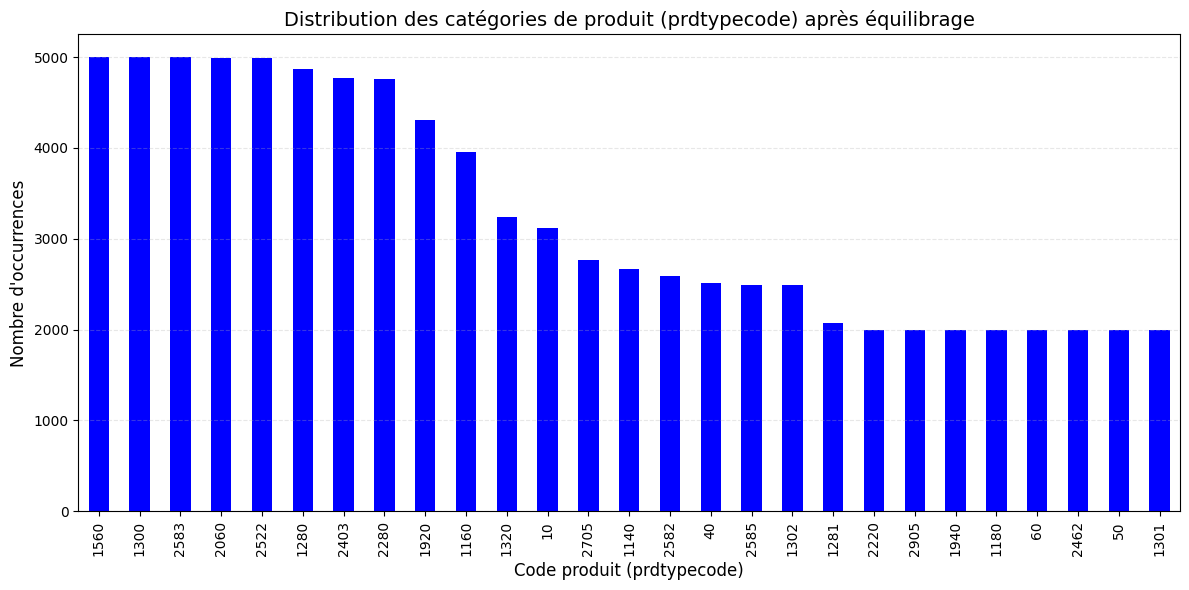

In [ ]:
# Rééquilibrage des classes (2000 à 5000 lignes par prdtypecode)
min_samples = 2000
max_samples = 5000
balanced = []

print("Rééquilibrage des classes en cours...")
for cat in tqdm(df["prdtypecode"].unique(), desc="Catégories"):
    sub = df[df["prdtypecode"] == cat]
    if len(sub) < min_samples:
        sub = resample(sub, replace=True, n_samples=min_samples, random_state=42)
    elif len(sub) > max_samples:
        sub = resample(sub, replace=False, n_samples=max_samples, random_state=42)
    balanced.append(sub)

df_balanced = pd.concat(balanced).reset_index(drop=True)

# Calcul du nombre d'occurrences de chaque catégorie 'prdtypecode' après équilibrage
prdtypecode_counts_balanced = df_balanced['prdtypecode'].value_counts()
print("\nRépartition des classes après équilibrage :")
print(prdtypecode_counts_balanced)

# Visualisation
plt.figure(figsize=(12, 6))

prdtypecode_counts_balanced.plot(kind='bar', color='blue')
plt.title("Distribution des catégories de produit (prdtypecode) après équilibrage", fontsize=14)
plt.xlabel("Code produit (prdtypecode)", fontsize=12)
plt.ylabel("Nombre d'occurrences", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Encodage du label avec LabelEncoder
le = LabelEncoder()
df_balanced["label"] = le.fit_transform(df_balanced["prdtypecode"])
df_balanced.head()

,prdtypecode,texte,image_path,texte_nettoye,langue,texte_nettoye_traduit,label
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,Olivia: cahier personnalisé / 150 pages / gril...,0
1,10,Christof E: Bildungsprozessen Auf Der Spur,image_907794536_product_91920807.jpg,Christof E: Bildungsprozessen Auf Der Spur,de,Christof E: Sur la piste des processus éducatifs,0
2,10,Vassivière -En-Limousin. Le Jardin Art Et Lie...,image_1010065513_product_444108636.jpg,Vassivière -En-Limousin. Le Jardin Art Et Lieu...,fr,Vassivière -En-Limousin. Le Jardin Art Et Lieu...,0
3,10,Dr. Mercurius' Heilsame Reise Zum Planeten Erde,image_1204663650_product_1807806498.jpg,Dr. Mercurius' Heilsame Reise Zum Planeten Erde,de,Voyage de guérison du Dr Mercurius vers la pla...,0
4,10,La Promenade Au Parc,image_880172152_product_125293048.jpg,La Promenade Au Parc,fr,La Promenade Au Parc,0


In [ ]:
# Mapping des labels vers prdtypecode et libellé
prdtypecode_to_label = {
    10: "Livres", 40: "Jeux Vidéo", 50: "Accessoires jeux vidéos", 60: "Jeux vidéo & Consoles",
    1140: "Figurines", 1160: "Cartes de jeux", 1180: "Jeux de rôle et de figurines", 1280: "Jouets & Enfant",
    1281: "Jeux de société", 1300: "Véhicules RC & miniatures", 1301: "Chaussettes bébé", 1302: "Sports & Loisirs",
    1320: "Puériculture", 1560: "Maison", 1920: "Linge de maison", 1940: "Petit déjeuner", 2060: "Décoration",
    2220: "Animalerie", 2280: "Revue", 2403: "Lots Livres & Revues", 2462: "Lots consoles & jeux",
    2522: "Fournitures Papeterie", 2582: "Mobilier de jardin", 2583: "Équipement piscine & spa",
    2585: "Outillage de jardin", 2705: "eBooks", 2905: "Jeux en téléchargement"
}

mapping = {
    str(i): {
        "prdtypecode": int(code),
        "label_name": prdtypecode_to_label[int(code)]
    }
    for i, code in enumerate(le.classes_)
}

print(mapping)

{'0': {'prdtypecode': 10, 'label_name': 'Livres'}, '1': {'prdtypecode': 40, 'label_name': 'Jeux Vidéo'}, '2': {'prdtypecode': 50, 'label_name': 'Accessoires jeux vidéos'}, '3': {'prdtypecode': 60, 'label_name': 'Jeux vidéo & Consoles'}, '4': {'prdtypecode': 1140, 'label_name': 'Figurines'}, '5': {'prdtypecode': 1160, 'label_name': 'Cartes de jeux'}, '6': {'prdtypecode': 1180, 'label_name': 'Jeux de rôle et de figurines'}, '7': {'prdtypecode': 1280, 'label_name': 'Jouets & Enfant'}, '8': {'prdtypecode': 1281, 'label_name': 'Jeux de société'}, '9': {'prdtypecode': 1300, 'label_name': 'Véhicules RC & miniatures'}, '10': {'prdtypecode': 1301, 'label_name': 'Chaussettes bébé'}, '11': {'prdtypecode': 1302, 'label_name': 'Sports & Loisirs'}, '12': {'prdtypecode': 1320, 'label_name': 'Puériculture'}, '13': {'prdtypecode': 1560, 'label_name': 'Maison'}, '14': {'prdtypecode': 1920, 'label_name': 'Linge de maison'}, '15': {'prdtypecode': 1940, 'label_name': 'Petit déjeuner'}, '16': {'prdtypecode'

In [ ]:
# Sauvegardes "finales"

# Définition des chemins de sauvegarde pour les fichiers finaux
save_csv = os.path.join(final_path, "X_train_fr_final.csv")              # Dataset équilibré (texte traduit, prêt pour entraînement)
save_encoder = os.path.join(final_path, "label_encoder_final.pkl")       # Encodeur de labels (LabelEncoder sauvegardé avec joblib)
save_json = os.path.join(final_path, "label_mapping_final.json")         # Mapping des labels vers prdtypecode et libellé (pour déploiement)

# Sauvegarde du DataFrame final équilibré au format CSV
df_balanced.to_csv(save_csv, index=False)

# Sauvegarde de l'encodeur de labels avec joblib
joblib.dump(le, save_encoder)

# Sauvegarde du dictionnaire de mapping sous forme JSON
with open(save_json, "w", encoding="utf-8") as f:
    json.dump(mapping, f, indent=4, ensure_ascii=False)  # UTF-8 conservé, indentation pour lisibilité

# Logs finaux : affichage des chemins des fichiers sauvegardés et statistiques des classes
print(f"\nFichier final enregistré : {save_csv}")
print(f"LabelEncoder sauvegardé : {save_encoder}")
print(f"Mapping JSON sauvegardé : {save_json}")


Fichier final enregistré : /content/drive/MyDrive/Colab Notebooks/data/X_train_fr_final.csv
LabelEncoder sauvegardé : /content/drive/MyDrive/Colab Notebooks/data/label_encoder_final.pkl
Mapping JSON sauvegardé : /content/drive/MyDrive/Colab Notebooks/data/label_mapping_final.json


In [ ]:
!pip freeze > "/content/drive/MyDrive/Colab Notebooks/requirements_Data.txt"